Mapped classes: [0 1 2 3 4 5 6]
Original label mapping: {np.int32(1): 0, np.int32(2): 1, np.int32(3): 2, np.int32(4): 3, np.int32(5): 4, np.int32(6): 5, np.int32(7): 6}
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Random Forest Best Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 2 folds for each of 2 candidates, totalling 4 fits
XGBoost Best Params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 1}

=== Random Forest (Tuned) Evaluation ===
Accuracy: 0.8891508825073363
F1-score: 0.8871141441917179

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88     42368
           1       0.87      0.94      0.90     56661
           2       0.92      0.93      0.92      7151
           3       0.90      0.84      0.87       549
           4       0.97      0.39      0.56      1899
           5       0.91      0.79      0.85      3473
           6       0.

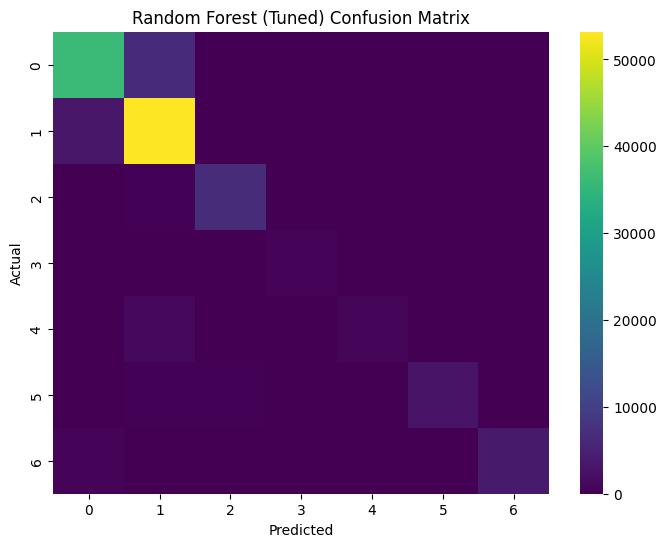


=== XGBoost (Tuned) Evaluation ===
Accuracy: 0.8962677383544315
F1-score: 0.8956250457549797

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88     42368
           1       0.89      0.92      0.91     56661
           2       0.92      0.92      0.92      7151
           3       0.90      0.85      0.88       549
           4       0.89      0.61      0.72      1899
           5       0.87      0.83      0.85      3473
           6       0.96      0.94      0.95      4102

    accuracy                           0.90    116203
   macro avg       0.91      0.85      0.87    116203
weighted avg       0.90      0.90      0.90    116203



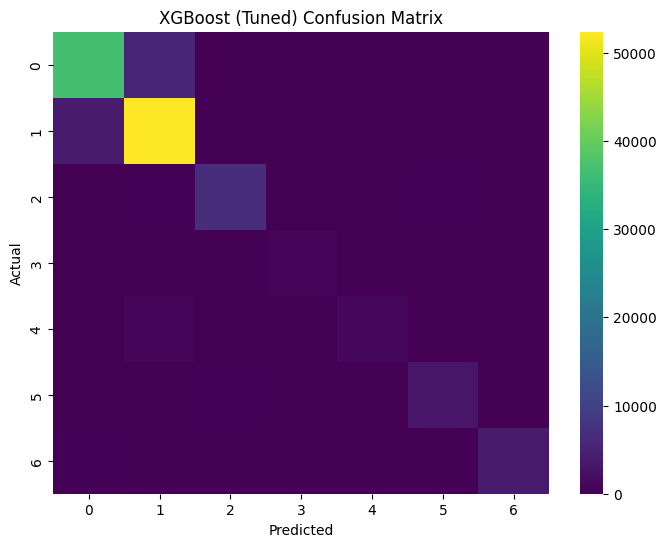


=== Logistic Regression Evaluation ===
Accuracy: 0.7232429455349689
F1-score: 0.7137218124747846

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.70      0.70     42368
           1       0.75      0.80      0.77     56661
           2       0.68      0.80      0.73      7151
           3       0.60      0.43      0.50       549
           4       0.16      0.01      0.01      1899
           5       0.50      0.28      0.36      3473
           6       0.74      0.56      0.63      4102

    accuracy                           0.72    116203
   macro avg       0.59      0.51      0.53    116203
weighted avg       0.71      0.72      0.71    116203



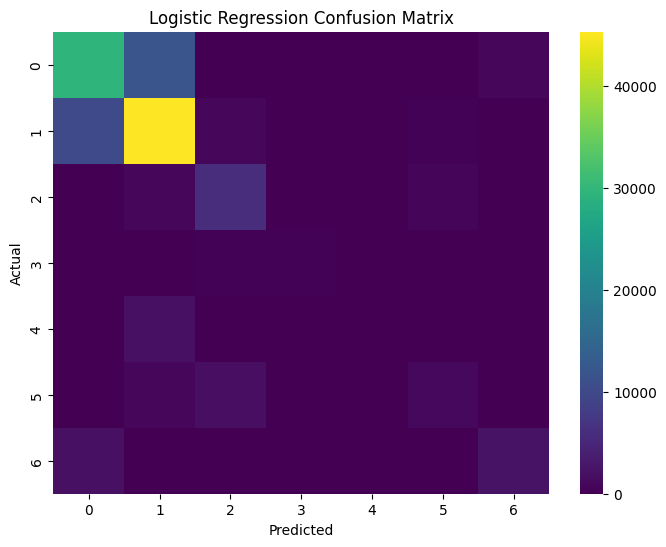

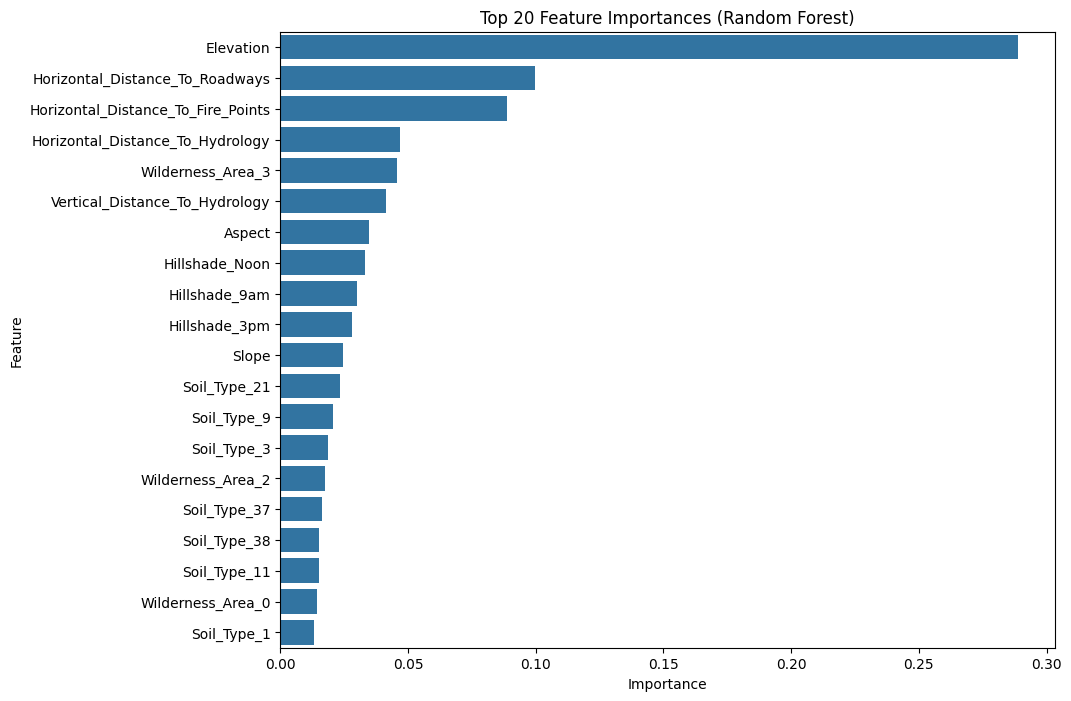


=== Model Comparison ===
                 Model  Accuracy  F1-score
0        Random Forest  0.889151  0.887114
1              XGBoost  0.896268  0.895625
2  Logistic Regression  0.723243  0.713722


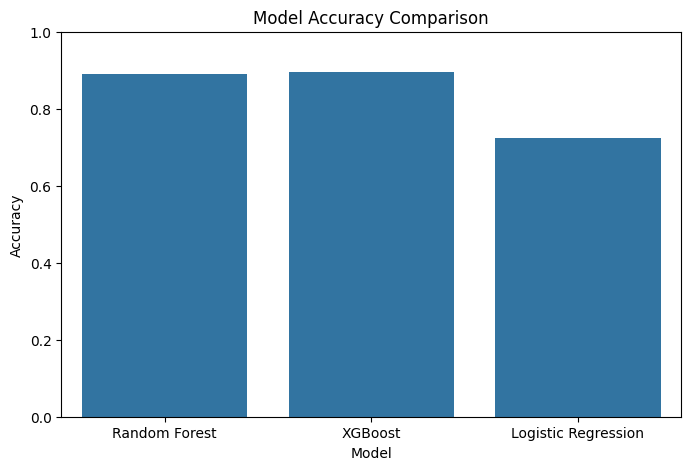

In [ ]:
!pip install xgboost --quiet
!pip install seaborn --quiet
!pip install scikit-learn --quiet
!pip install pandas --quiet
!pip install matplotlib --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

cov = fetch_covtype()
X = pd.DataFrame(cov.data, columns=cov.feature_names)
y = pd.Series(cov.target)

unique_labels = np.sort(y.unique())
label_mapping = {old: new for new, old in enumerate(unique_labels)}
y = y.map(label_mapping)
print("Mapped classes:", np.unique(y))
print("Original label mapping:", label_mapping)

continuous_cols = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]

scaler = StandardScaler()
X[continuous_cols] = scaler.fit_transform(X[continuous_cols])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf_params = {
    'n_estimators': [100],
    'max_depth': [10, 20],
    'min_samples_split': [2]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_params, cv=2, scoring='accuracy', verbose=1
)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
rf_preds = rf_best.predict(X_test)
print("Random Forest Best Params:", rf_grid.best_params_)

xgb_params = {
    'n_estimators': [100],
    'max_depth': [6, 10],
    'learning_rate': [0.1],
    'subsample': [1]
}

xgb_model = xgb.XGBClassifier(
    use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1
)
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=2, scoring='accuracy', verbose=1)
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_
xgb_preds = xgb_best.predict(X_test)
print("XGBoost Best Params:", xgb_grid.best_params_)

lr_model = LogisticRegression(max_iter=1000, multi_class='multinomial')
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

def evaluate_model(y_true, y_pred, model_name):
    print(f"\n=== {model_name} Evaluation ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred, average='weighted'))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=False, fmt='d', cmap='viridis')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

evaluate_model(y_test, rf_preds, "Random Forest (Tuned)")
evaluate_model(y_test, xgb_preds, "XGBoost (Tuned)")
evaluate_model(y_test, lr_preds, "Logistic Regression")

importances = rf_best.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances (Random Forest)')
plt.show()

results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Logistic Regression'],
    'Accuracy': [
        accuracy_score(y_test, rf_preds),
        accuracy_score(y_test, xgb_preds),
        accuracy_score(y_test, lr_preds)
    ],
    'F1-score': [
        f1_score(y_test, rf_preds, average='weighted'),
        f1_score(y_test, xgb_preds, average='weighted'),
        f1_score(y_test, lr_preds, average='weighted')
    ]
})

print("\n=== Model Comparison ===")
print(results)

plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='Accuracy', data=results)
plt.title('Model Accuracy Comparison')
plt.ylim(0,1)
plt.show()